# Modélisation de courbes de taux
---
- DEBA WANDJI Franck Delma
- KOUGOUM MOKO MANI Marilene
- MBAIORNOM MBAIHODJI Fernand
---

**ENSAI 3A : DATA SCIENCE ET GESTION DES RISQUES**

---

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.interpolate import interp1d, CubicSpline
from tabulate import tabulate
from scipy.stats import norm

# Reconstitution d’une courbe de taux zéro-coupon
---
## Formules de valorisation des taux de marché
---


1. Le tableau \ref{tab:courbe-de-marché} décrit une courbe de taux interbancaires.
    En effet, les instruments qu'il contient, et desquels on derivera nos taux zero coupons pour differentes maturités, sont essentiellement des taux de marché monétaire (money market), des contrats futures et des swaps.

2. Ce tableau contient trois types d'instruments financiers:
   -  **Des Money market** :  Il s'agit des taux (monétaires) à court terme sur le marché interbancaire. Dans le contexte de notre exercice, il s'agit de taux Libor  pour les maturités allant de 3 mois à 1 an.

   - **Des contrats futures de taux d'intérêt** :Ce sont des instruments financiers négociés sur un marché réglementé, permettant aux acteurs du marché 
        de s’engager dès aujourd’hui sur l’évolution d’un taux d’intérêt futur à un niveau prédéfini. Ils sont utilisés aussi bien à des fins de couverture contre le risque de taux que pour la spéculation. Afin de limiter le risque de contrepartie, ces contrats sont sujets à des appels de marge quotidiens. Le tableau\ref{tab:courbe-de-marché} présente des futures de taux d’intérêt avec des maturités comprises entre 1.25 et 2.75 ans.
        
       
   - **Des swaps de taux d'intérêts**: Un swap de taux d’intérêt est un contrat entre deux parties visant à échanger des flux financiers basés sur un montant notionnel déterminé. Généralement, l’une des parties verse des paiements à taux fixe, tandis que l’autre paie des intérêts à taux variable, indexés sur un indice de référence (dans notre cas, le Libor). Cet échange suit un échéancier prédéfini et permet aux acteurs du marché  de se couvrir contre le risque de taux d’intérêt ou d’optimiser leurs coûts de financement.
        Le tabeau \ref{tab:courbe-de-marché} contient des Swaps dont les tenors vont de 3 à 30 ans
    \end{itemize}

    Sous l'hypothèse d'absence d'opportunuité d'arbitrage ces instruments sont valorisés par les formules suivantes:
    
     - Money Market (Taux libor): Etant donné une période d'intérêt $[T, T+\delta]$, la valeur du tau libor vu aujourd'hui est donnée par
        $$
        \begin{equation}
        L_0(T,T+\delta) = \frac{1}{\delta} \left( \frac{B(0,T)}{B(0,T + \delta)} - 1 \right)
        \end{equation}
        $$

      - La valeur vue d'aujourd'hui du future de taux d'intérêt pour la date de départ $T$ et de tenor $T+\delta$ est donnée par:
        $$
        \begin{equation}
        F(0,T, T+\delta) = 1 - L_0(T,T+\delta)
        \end{equation}
        $$

     -  Etant donné les échéanciers $(t_i)_{i=0,...,m} $(pour la jambe fixe) et $(t_j)_{j=0,...,n}$ (pour la jambe flottante),  on définit le swap à départ $T_0 = t_0 = \tilde{t}_0$ et de maturité $T_n = t_m = \tilde{t}_n$.        On introduit les nominaux respectifs de chaque jambe $(N_i)_{i=1,...,m}$ et $( \tilde{N})_{j=1,...,n}$ ainsi que les taux fixes $(K_i)_{i=1,...,m}$ et les spreads $(s_i)_{i=1,...,m}$.
        
         A la date de pricing t = 0, le prix du swap est donnée par:

        $$
        \begin{equation}
        S_0(T_0, T) = \frac{\sum_j^n \tilde{N}_j(\tilde{t}_j - \tilde{t}_{j-1})(L(\tilde{t}_{j-1}, \tilde{t}_j) + s_j)B(0, \tilde{t}_j)}{\sum_i^m N_i(t_i-t_{i-1})B(0,t_i)}
        \end{equation}
        $$


3. Rappelons le principe du bootstrapping et son importance.

    Le principe de base du bootstrapping est de restituer - à partir de l’information disponible sur le marché -  une courbe de taux zéro-coupon
    discrète à l’aide d’une approche récursive.

    Cette méthode est essentielle car il n’existe pas sur le marché un continuum de cotations d’obligations zéro-coupon; ceci rend impossible l’obtention directe des taux zéro-coupon pour toutes les maturités. Le bootstraping constitue donc un outil indispensable pour la construction de la courbe des taux zéro-coupon par terme, qui est la brique fondamentale pour la valorisation des instruments financiers. 

4. Rappelons la différence entre une opération forward et future.

    La différence entre un **contrat forward** et un **contrat future** réside principalement dans leur mode de négociation et de règlement. Un forward est un contrat **de gré à gré**, réglé en un **unique paiement à l’échéance**, correspondant à la différence entre le taux négocié et le taux de marché réalisé. À l’inverse, un future est  **standardisé et négocié sur un marché réglementé**, avec un ajustement **quotidien** de sa valeur via des **appels de marge** (mark-to-market), répartissant ainsi les gains et pertes tout au long de la durée du contrat.

    
---
---
## Construction de la courbe des taux zéro-coupon
---

1. L’interpolation des taux de swap pour obtenir des cotations annuelles simplifie la méthode du bootstrap en fournissant une courbe de taux continue pour toutes les maturités. Cela aligne les échéances des instruments de marché avec celles utilisées dans la construction de la courbe zéro-coupon, évitant ainsi de gérer des échéances intermédiaires ou irrégulières. Avec des intervalles de temps constants égaux à 1 an, les calculs deviennent plus simples et plus directs, permettant une extraction précise des taux zéro-coupon à chaque étape.

2. Construisons sur le segment des SWAP une nouvelle courbe de taux de marché avec des cotations annuelles obtenues à l’aide d’une méthode d’interpolation par spline.


In [2]:
# Import data
df = pd.read_excel("Data.xlsx")
df.columns = ["Market", "MAT", "MKT"]
df.head()

,Market,MAT,MKT
0,MM,0.25,0.030698
1,MM,0.50,0.026191
2,MM,0.75,0.023958
3,MM,1.00,0.022979
4,FUT,1.25,0.978691


In [3]:

def interpolation_spline_swap(df):
    df_swap = df[df["Market"] == 'SWAP']
    # Appliquons une interpolation spline cubique
    cs = CubicSpline(df_swap['MAT'].values, df_swap['MKT'].values)

    # générons les points pour l'affichage de la courbe 
    maturities_gen = np.linspace(min(df_swap['MAT'].values), max(df_swap['MAT'].values), 100)

    swap_rate_gen = cs(maturities_gen)
    data_gen = {
        "Market": ['SWAP'] * len(maturities_gen),
        'MAT': maturities_gen.tolist(),
        'MKT': swap_rate_gen.tolist()
    }

    data_gen = pd.DataFrame(data_gen)
    return data_gen

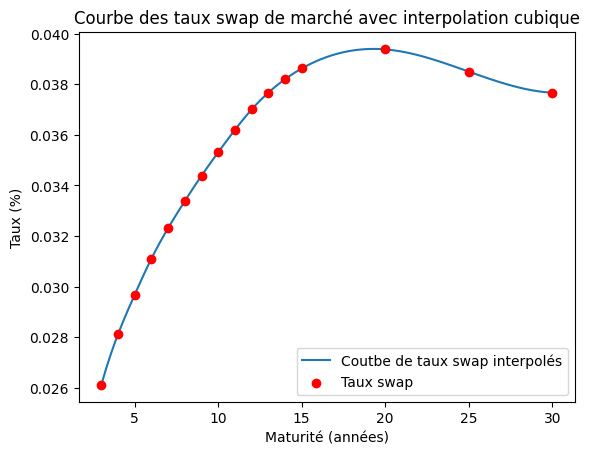

In [4]:
data_swap =  interpolation_spline_swap(df)
plt.plot(data_swap['MAT'].values,data_swap['MKT'].values, label ="Coutbe de taux swap interpolés")
plt.scatter(df[df["Market"]== "SWAP"]['MAT'].values,df[df["Market"]== "SWAP"]['MKT'].values,color = "red", label = "Taux swap", zorder =3)

plt.title("Courbe des taux swap de marché avec interpolation cubique")
plt.xlabel("Maturité (années)")  # Axe des abscisses
plt.ylabel("Taux (%)")

plt.legend()
plt.show()

**Dans la suite, on supposera que pour ce segment, cette nouvelle courbe est la courbe de marché de référence** 

---


3. Calculons à présent les taux zéro-coupon continus associés à toutes les maturités de marché.

    En appliquant le principe de bootstrap, les expressions énoncées en (1), (2), (3) , nous permettent d'obtenir de manière recursive les prix d'obligations zero coupons pour differentes maturités à partir des taux de marché.

    Des prix de ces obligations zéro-coupons, on déduit le taux zéro-coupon par le calcul suivant :  

    $$
    B(0, T) = \exp(-R(0,T) \cdot T) \implies R(0,T) = -\frac{\ln(B(0,T))}{T}
    $$


    **Stripping**

    Nous utilisons trois méthodes pour réaliser l’interpolation de la
    courbe discrète des taux zéro-coupon obtenue via le bootstrapping précédent.

    
    - *Une interpolation linéaire par morceaux (taux zéro-coupon)*:
        l'hypothèse est que la fonction  $R(0,T)$  est linéaire entre deux maturités successives  $T_{i-1}$  et  $T_i $ :

        $$
        R(0,T) = \lambda_i(T) R(0,T_i) + (1 - \lambda_i(T)) R(0,T_{i-1}), \quad \text{pour } T \in [T_{i-1}, T_i]
        $$

        avec :

        $$
        \lambda_i(T) = \frac{T - T_{i-1}}{T_i - T_{i-1}}
        $$

    - *Une interpolation log-linéaire par morceaux (prix des obligations zéro-coupon)*:
        on suppose que la fonction \( B(0,T) \) est log-linéaire par morceaux

        $$
            R(0,T) \cdot T = \lambda_i(T) R(0,T_i) T_i + (1 - \lambda_i(T)) R(0,T_{i-1}) T_{i-1}, \quad \text{pour } T \in [T_{i-1}, T_i]
        $$

        où  $\lambda_i(T)$ est défini comme précédemment.

    - *Une interpolation par spline cubique*

  Pour ces trois méthodes, la courbe de taux interpolée a le même allure comme illustrée ci-après \ref{fig:ZC_spline}: \textcolor{red}{si possible, superposer les deux courbes


In [27]:
def bootstrap_yield_curve(df):
    """
    Bootstrap a yield curve from market data using cubic spline interpolation.

    Parameters:
        df (pd.DataFrame): Market data with columns ["Market", "MAT", "MKT"].

    Returns:
        pd.DataFrame: Yield curve with zero-coupon rates.
    """
    # Convert DataFrame into dictionary for faster lookup
    data = {market: df[df["Market"] == market].reset_index(drop=True) for market in ["MM", "FUT", "SWAP"]}

    # Step 1: Interpolate Swap Rates
    swap_data = data["SWAP"]
    spline = CubicSpline(swap_data["MAT"], swap_data["MKT"])
    maturities_annual = np.arange(3, 31, 1)
    interpolated_rates = spline(maturities_annual)

    # Combine interpolated data
    SWAP_interpolated = pd.DataFrame({"Market": "SWAP", "MAT": maturities_annual, "MKT": interpolated_rates})
    df_new = pd.concat([df[df["Market"] != "SWAP"], SWAP_interpolated])

    # Update data dictionary
    data["MM"] = df_new[df_new["Market"] == "MM"].reset_index(drop=True)
    data["FUT"] = df_new[df_new["Market"] == "FUT"].reset_index(drop=True)
    data["SWAP"] = df_new[df_new["Market"] == "SWAP"].reset_index(drop=True)

    # Step 2: Compute Zero-Coupon Rates for MM
    data["MM"]["B(0,MAT)"] = 1 / (1 + data["MM"]["MAT"] * data["MM"]["MKT"])
    data["MM"]["tx ZC"] = -np.log(data["MM"]["B(0,MAT)"]) / data["MM"]["MAT"]

    # Step 3: Compute Zero-Coupon Rates for Futures
    data["FUT"]["B(0,MAT)"] = data["MM"]["B(0,MAT)"].iloc[-1]
    B_tau_i = data["FUT"].iloc[0]["B(0,MAT)"]
    tau_i = 1

    for i, row in data["FUT"].iterrows():
        T_i, f_i = row["MAT"], row["MKT"]
        B_tau_i /= (1 + (T_i - tau_i) * (1 - f_i))
        data["FUT"].at[i, "B(0,MAT)"] = B_tau_i
        tau_i = T_i

    data["FUT"]["tx ZC"] = -np.log(data["FUT"]["B(0,MAT)"]) / data["FUT"]["MAT"]

    # Step 4: Compute Zero-Coupon Rates for Swaps
    B_T_1 = data["MM"].loc[data["MM"]["MAT"] == 1, "B(0,MAT)"].values[0]
    B_T_2 = data["FUT"].loc[data["FUT"]["MAT"] == 2, "B(0,MAT)"].values[0]
    A = B_T_1 + B_T_2

    data["SWAP"]["B(0,MAT)"] = (1 - data["SWAP"]["MKT"].iloc[0] * A) / (1 + data["SWAP"]["MKT"].iloc[0])

    for i in range(1, len(data["SWAP"])):
        A += data["SWAP"].iloc[i - 1]["B(0,MAT)"]
        data["SWAP"].at[i, "B(0,MAT)"] = (1 - data["SWAP"].iloc[i]["MKT"] * A) / (1 + data["SWAP"].iloc[i]["MKT"])

    data["SWAP"]["tx ZC"] = -np.log(data["SWAP"]["B(0,MAT)"]) / data["SWAP"]["MAT"]

    # Combine results
    yield_curve = pd.concat(data.values())

    return yield_curve


In [ ]:
# Application du bootstraping

yield_zc = bootstrap_yield_curve(df)

In [ ]:
# Fonction pour appliquer le stripping

def zc_interpolation(yield_curve):
    """
    Calcule les taux forward 3M à partir des taux zéro-coupon.
    
    Parameters:
    yield_curve (pd.DataFrame): Contient 'MAT' (maturité) et 'B(0,MAT)' (Prix ZC).
    
    Returns:
    pd.DataFrame: Contenant 'MAT' et 'Forward 3M'.
    """
    
    # Convertir les maturités en mois
    yield_curve["MAT_months"] = yield_curve["MAT"] * 12
    
    # Sélection des maturités tous les 3 mois
    maturities = np.arange(3, max(yield_curve["MAT_months"]), 3) / 12  # en années

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation log-linéaire sur B(0,T) pour estimer tx ZC pour ces maturités
    temp = interp1d(yield_curve["MAT"], np.log(yield_curve["B(0,MAT)"]), kind="linear", fill_value="extrapolate")
    log_interp_zc = -np.log(temp(maturities)) / maturities
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation linéaire sur les tx ZC 
    temp = interp1d(yield_curve["MAT"], yield_curve["tx ZC"], kind="linear", fill_value="extrapolate")
    lin_interp_zc = temp(maturities)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation cubic des tx ZC pour estimer B(0,T) pour ces maturités
    temp  = CubicSpline(yield_curve["MAT"], yield_curve["tx ZC"])
    spline_interp_zc = temp(maturities)
    
    return {"MAT": maturities,
                        "Interpolation Linéaire": lin_interp_zc,
                        "Interpolation log-linéaire": log_interp_zc,
                        "Interpolation Spline": spline_interp_zc}
    

def plot_curve(forward_rates, columns = ["Interpolation Spline", "Interpolation Linéaire"], title= "Courbe des Taux Forwards 3M"):
    """
    Trace la courbe des taux forwards en utilisant l'interpolation linéaire et spline.
    
    Parameters:
    forward_rates (pd.DataFrame): Contenant 'MAT' et 'Forward 3M'.
    """
    # Tracé des courbes
    plt.figure(figsize=(10, 6))
    for col in columns:
        plt.plot(forward_rates["MAT"], forward_rates[col],  label=col)
    

    plt.xlabel("Maturité (années)")
    plt.ylabel("Taux d'intérêt")
    plt.title(f"{title}")
    plt.legend()
    plt.grid()
    plt.show()


C:\Users\DEBA\AppData\Local\Temp\ipykernel_24336\496344957.py:23: RuntimeWarning: invalid value encountered in log
  log_interp_zc = -np.log(temp(maturities)) / maturities


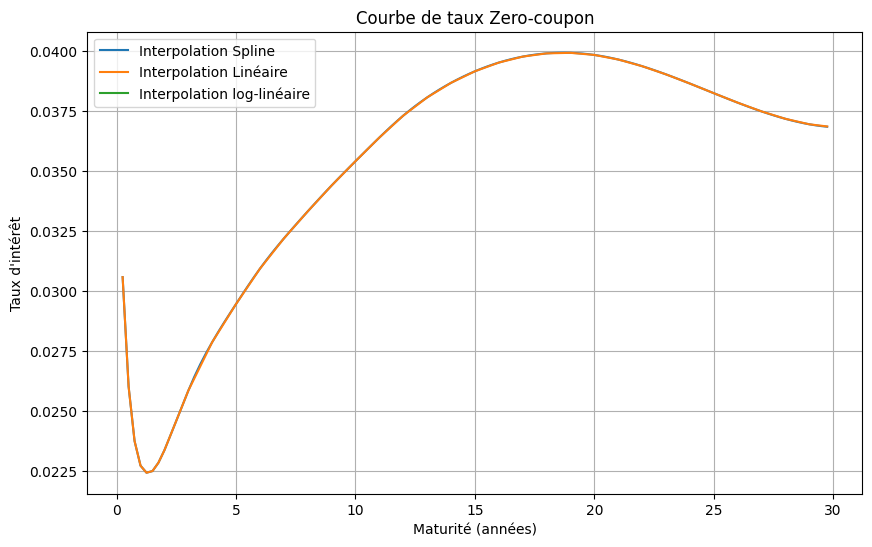

In [30]:
# Application du stripping
courbe_zc = pd.DataFrame(zc_interpolation(yield_zc))

# Tracé des courbes interpolées
plot_curve(courbe_zc,
           columns = ["Interpolation Spline", "Interpolation Linéaire","Interpolation log-linéaire"],
           title= "Courbe de taux Zero-coupon")


4.  Le mode d’interpolation des taux zéro-coupon a un impact direct sur le calcul des taux de marché, car il conditionne **la forme** et **la régularité** de la courbe des taux. En particulier, les méthodes d'interpolation linéaires et log-linéaires génèrent de fortes irrégularités sur la courbe des taux forward implicite.
    Ceci peut s'expliquer par le fait que l’information de marché est très dispersée sur la partie swap. Ceci étant principalement dû à l’espacement important entre les maturités des taux swap consécutifs observés, qui s’étend sur une année dans notre cas.  Ainsi, ces deux méthodes d’interpolation standards sont
    souvent inadaptées en terme de lissage des courbes implicites.

---


## Construction de la courbe des taux forward
---

1. À partir de la courbe des taux zéro-coupon obtenue par bootstrapping, traçons la courbe des taux forwards 3Mois en fonction de la maturité en utilisant les differentes méthodes d'interpolation présentées précédemment.

Le graphique ci après présente les courbes de taux forward 3 mois  obtenue en fonction des différentes méthodes d'interpolation.


In [ ]:
# Courbe des taux forward de tenor 3 mois

def compute_forward_rates(yield_curve):
    """
    Calcule les taux forward 3M à partir des taux zéro-coupon.
    
    Parameters:
    yield_curve (pd.DataFrame): Contient 'MAT' (maturité) et 'B(0,MAT)' (Prix ZC).
    
    Returns:
    pd.DataFrame: Contenant 'MAT' et 'Forward 3M'.
    """
    
    # Convertir les maturités en mois
    yield_curve["MAT_months"] = yield_curve["MAT"] * 12
    
    # Sélection des maturités tous les 3 mois
    maturities = np.arange(3, max(yield_curve["MAT_months"]), 3) / 12  # en années

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation log-linéaire sur B(0,T) pour estimer B(0,T) pour ces maturités
    log_interp_bond_prices = interp1d(yield_curve["MAT"], np.log(yield_curve["B(0,MAT)"]), kind="linear", fill_value="extrapolate")
    
    # Calcul des prix interpolés
    B_t = np.exp(log_interp_bond_prices(maturities))
    B_t_3M = np.exp(log_interp_bond_prices(maturities + 0.25))  # 3 mois plus tard

    # Calcul du taux forward 3M
    forward_rates_log = ((B_t / B_t_3M) - 1)/0.25
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation linéaire sur les tx ZC pour estimer B(0,T) pour ces maturités
    lin_interp_bond_prices = interp1d(yield_curve["MAT"], yield_curve["tx ZC"], kind="linear", fill_value="extrapolate")
    
    # Calcul des prix interpolés
    B_t = np.exp(-lin_interp_bond_prices(maturities)*maturities)
    B_t_3M = np.exp(-lin_interp_bond_prices(maturities + 0.25)*(maturities + 0.25))  # 3 mois plus tard

    # Calcul du taux forward 3M
    forward_rates_lin = ((B_t / B_t_3M) - 1)/0.25
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Interpolation cubic des tx ZC pour estimer B(0,T) pour ces maturités
    spline_interp_bond_prices = CubicSpline(yield_curve["MAT"], yield_curve["tx ZC"])
    
    # Calcul des prix interpolés
    B_t = np.exp(-spline_interp_bond_prices(maturities)*maturities)
    B_t_3M = np.exp(-spline_interp_bond_prices(maturities + 0.25)*(maturities + 0.25))  # 3 mois plus tard

    # Calcul du taux forward 3M
    forward_rates_spline = ((B_t / B_t_3M) - 1)/0.25
    
    

    return {"MAT": maturities,
                        "Interpolation Linéaire": forward_rates_lin,
                        "Interpolation log-linéaire": forward_rates_log,
                        "Interpolation Spline": forward_rates_spline}

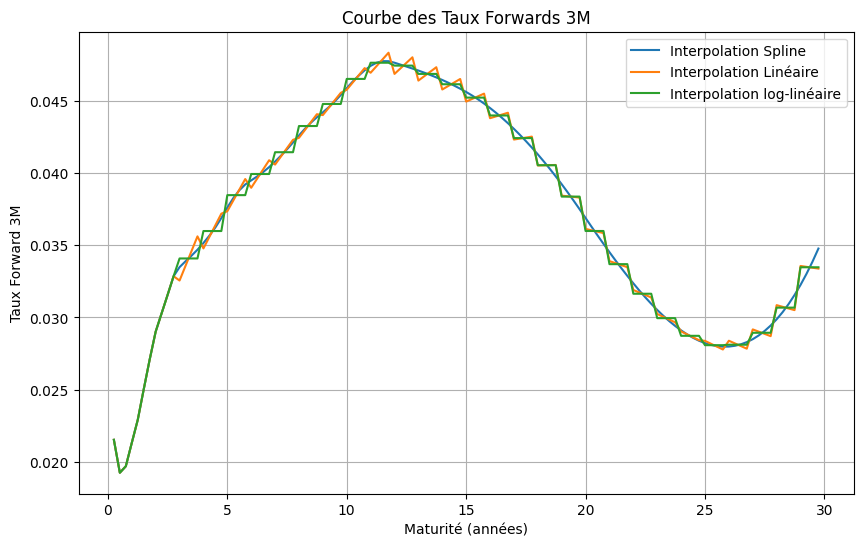

In [15]:
# Calcul de la courbe des taux forwards
forward_rates = pd.DataFrame(compute_forward_rates(yield_zc))

# Tracé des courbes interpolées
plot_curve(forward_rates, columns = ["Interpolation Spline", "Interpolation Linéaire","Interpolation log-linéaire"])


---
On constate des irrégularités pour les interpolations linéaires et log-linéaires,  contrairement à la courbe obtenue via une interpolation spline qui est plus lisse.

Les irrégularités observées pour les interpolations linéaires et log-linéaires sont observés à partir de la maturité 3 ans. Ceci est cohérent avec l'analyse faite plus haut. En effet, à partir de cette maturité, les taux zero coupons ont été extraits à partir de taux swap de marché.


2. Shiftons le taux de swap 5Y de 10 bps, puis expliquons l’impact sur les courbes des taux zéro-coupon et forward.


C:\Users\DEBA\AppData\Local\Temp\ipykernel_24336\496344957.py:23: RuntimeWarning: invalid value encountered in log
  log_interp_zc = -np.log(temp(maturities)) / maturities


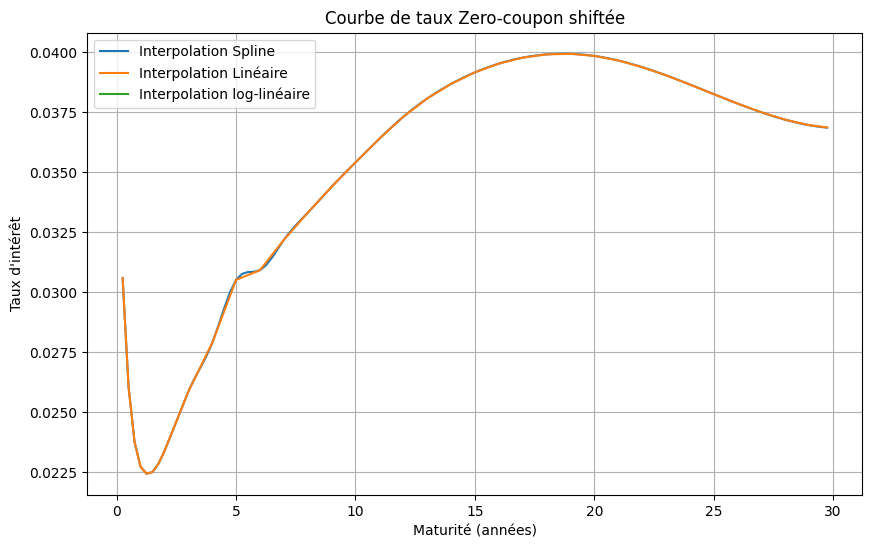

In [35]:
# 1bp = 0.01% donc 10bps = 0.10%=0.0001
df_bumped = yield_zc.copy()
df_bumped.loc[df_bumped["MAT"]==5,"MKT"] = df_bumped.loc[df_bumped["MAT"]==5,"MKT"] + 0.001
yield_bumped = bootstrap_yield_curve(df_bumped) # On refait le bootstraping

# Application du stripping
courbe_zc_bump = pd.DataFrame(zc_interpolation(yield_bumped))

# Tracé des courbes interpolées
plot_curve(courbe_zc_bump,
           columns = ["Interpolation Spline", "Interpolation Linéaire","Interpolation log-linéaire"],
           title= "Courbe de taux Zero-coupon shiftée")



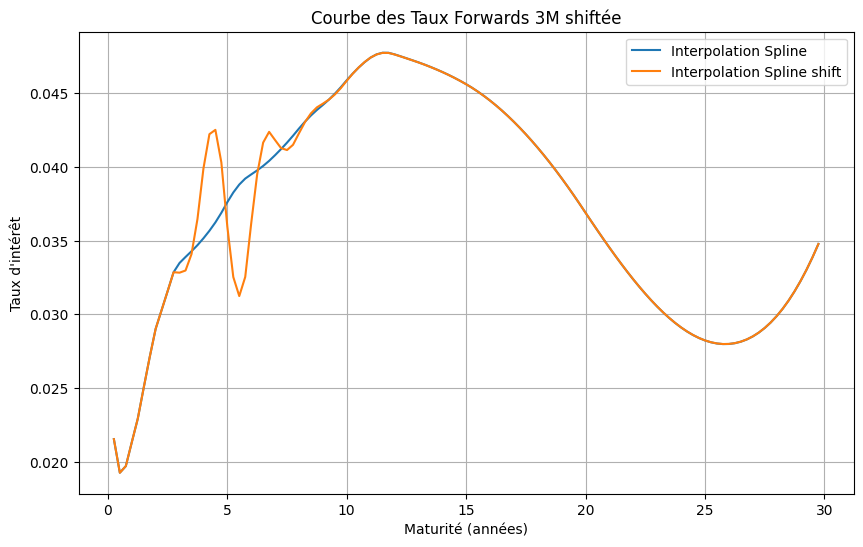

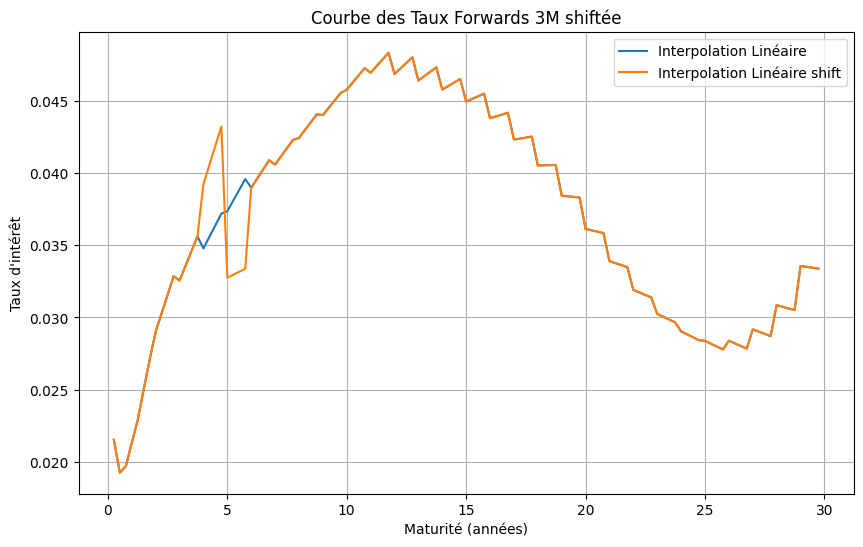

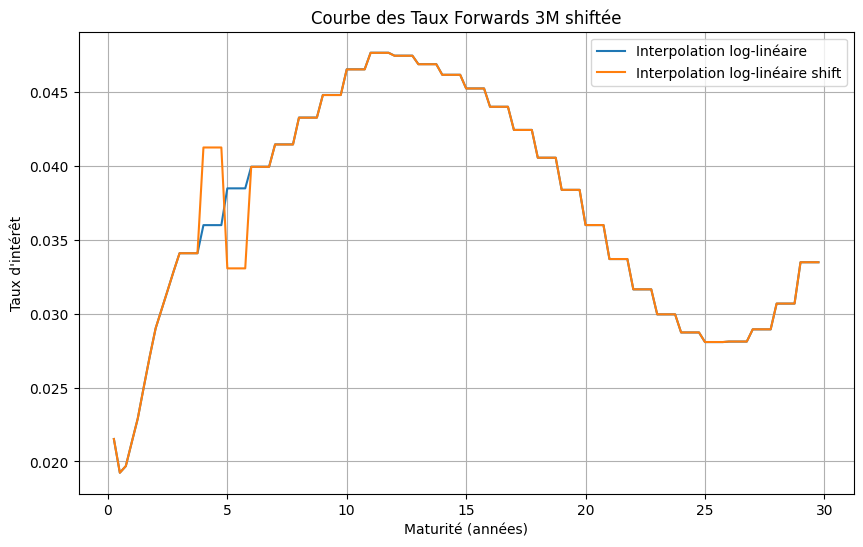

In [39]:
# Calcul de la courbe des taux forwards
forward_rates_bumped = pd.DataFrame(compute_forward_rates(yield_bumped))
forward_rates_bumped.rename(columns={"Interpolation Linéaire": "Interpolation Linéaire shift",
                                    "Interpolation log-linéaire": "Interpolation log-linéaire shift",
                                    "Interpolation Spline": "Interpolation Spline shift"}, inplace=True)

forward_rates_bumped = forward_rates_bumped.merge(forward_rates, on="MAT", how="inner")


# Tracé des courbes interpolées
plot_curve(forward_rates_bumped,
           columns=["Interpolation Spline", "Interpolation Spline shift"],
           title="Courbe des Taux Forwards 3M shiftée")  # On passe l'axe correspondant

plot_curve(forward_rates_bumped,
           columns=["Interpolation Linéaire", "Interpolation Linéaire shift"],
           title="Courbe des Taux Forwards 3M shiftée")  

plot_curve(forward_rates_bumped,
           columns=["Interpolation log-linéaire", "Interpolation log-linéaire shift"],
           title="Courbe des Taux Forwards 3M shiftée")



On observe que le shift de 10 bps sur le taux swap 5Y entraîne une modification des courbes de taux forward 3 mois, avec des effets qui varient selon la méthode d'interpolation utilisée.


Cette différence de comportement découle des propriétés des méthodes d’interpolation utilisées. L’interpolation **linéaire** et **log-linéaire** segmente l’évolution des taux entre deux maturités successives $T_{i-1}$  et $ T_i$ , en supposant une variation **linéaire** des taux zero coupons sur chaque intervalle. Ainsi, lorsqu’un **bump** est appliqué, son impact reste **localisé**, et les taux forward reviennent rapidement à leur trajectoire initiale.

À l’inverse, l’interpolation **spline** assure une transition plus **fluide** en imposant des contraintes de **régularité** sur la dérivée seconde. Cette régularité propage l’effet du **bump** de manière plus **progressive**, entraînant une déviation plus **large** et plus **persistante** des taux forward.

---
---
# Valorisation de swaptions et de caplets
---

1. Les caplets et floorlets, qui sont des options sur taux d'intérêt à court terme, sont généralement valorisés à l'aide du \textbf{modèle de Black}.

2. Rappelons les EDS des taux forwards, des taux de swap forward ainsi que les probabilités associées. \textcolor{red}{ A completer, je ne retrouve plus la page dans le cours}

3. Rappelons les formules de valorisation des oplets et swaptions.
    Un **caplet** (resp. floorlet) est une option d’achat (resp. de vente) sur un taux Libor. En
    notant  $T_{i-1}$ la date d’échéance de l’option,  et  $T_i$ la date de paiement fixé à la date, dans le modèle de Black, sa valorisation est donnée par :


    $$\text{Caplet}(t, T_{i-1}, T_i) = N \delta_i B(t,T_i) \left[ L_i(t) \Phi(d_1) - K \Phi(d_2) \right]$$

    
    $$\text{Floorlet}(t, T_{i-1}, T_i) = N \delta_i B(t,T_i) \left[ K \Phi(-d_2) - L_i(t) \Phi(-d_1) \right]$$
    
    avec :

    $$d_1 = \frac{\ln\left( \frac{L_i(t)}{K} \right) + \frac{1}{2} \sigma_i^2 (T_{i-1} - t)}{\sigma_i \sqrt{T_{i-1} - t}}, \quad
    d_2 = d_1 - \sigma_i \sqrt{T_{i-1} - t}$$
    

- $N $ est le nominal,
-  $\delta_i = T_i - T_{i-1}$  est le facteur de période associé au taux Libor,
-  $B(t,T_i)$  est le prix du zéro-coupon à maturité $T_i$ ,
-  $L_i(t)$  est le taux forward observé à  $t$ pour la période $[T_{i-1}, T_i]$,
-  $K$  est le taux d’exercice (strike),
-  $\sigma_i$  est la volatilité implicite du taux forward $L_i$,
-  $\Phi$ est la fonction de répartition de la loi normale standard.


    Une \textbf{swaption} est une option d’entrée dans un swap à une date future $T_0 $. Le prix d’une swaption $payeuse$ s’écrit :


    $\text{Swaption}(t) = N \sum_{j=1}^{n} B(t,T_j) \left[ F_S(t) \Phi(d_1) - K \Phi(d_2) \right]$
    

    et celui d’une swaption \textbf{receveuse} :


    $\text{Swaption}(t) = N \sum_{j=1}^{n} B(t,T_j) \left[ K \Phi(-d_2) - F_S(t) \Phi(-d_1) \right]$
    

    avec :
    
    $$d_1 = \frac{\ln\left( \frac{F_S(t)}{K} \right) + \frac{1}{2} \sigma^2 (T_0 - t)}{\sigma \sqrt{T_0 - t}}, $$
    $$d_2 = d_1 - \sigma \sqrt{T_0 - t}$$
    

    où $F_S(t)$  est le taux swap forward,  $\sigma$ la volatilité implicite de la swaption.


4.  A partir des cotations décrites dans le tableau \ref{} et de la courbe des taux zéro-coupon que nous avons construite précédemment, calculons les prix de marché de caplets sur euribor12M, de maturité 5Y et de strikes associés au tableau\ref{}.

Les valeurs des différents paramètres servant aux calculs sont essentiellement :  
- taux forward sur la période 5-6 ans $(0.039)$, 
- le $discount factor (0.830)$ - qui est la valeur d'une obligation zero coupon de maturité 6 ans-, 
- la $volatilité$ et le **strike** fournis dans l'énoncé.

In [59]:
def calculer_taux_forward(yield_curve, T):
    # Interpolation cubic des tx ZC pour estimer B(0,T) pour ces maturités
    spline_interp_bond_prices = CubicSpline(yield_curve["MAT"], yield_curve["tx ZC"])
    
    # Calcul des prix interpolés
    B_t = np.exp(-spline_interp_bond_prices(T)*T)
    B_t_3M = np.exp(-spline_interp_bond_prices(T + 0.25)*(T + 0.25))  # 3 mois plus tard

    # Calcul du taux forward 3M
    return  ((B_t / B_t_3M) - 1)/0.25

def prix_caplet(forward, strike, volatilite, T, delta=1):
    """
    Calcule le prix d'un caplet en utilisant la formule de Black.
    
    :param forward: Le taux forward pour la période donnée
    :param strike: Le strike du caplet en taux relatif
    :param volatilite: La volatilité implicite du caplet
    :param T: La maturité du caplet (en années)
    :param taux_zerocoupon: Le taux zéro-coupon pour la maturité T
    :return: Le prix du caplet
    """
    # Calcul des d1 et d2 pour la formule de Black
    d1 = (np.log(forward / strike) + 0.5 * volatilite**2 * T) / (volatilite * np.sqrt(T))
    d2 = d1 - volatilite * np.sqrt(T)
    
    # Fonction de répartition normale
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)

    
    # Calcul du discount factor
    taux_zc_T_plus_delta = yield_zc[yield_zc['MAT'] == T + delta]["tx ZC"].values[0]
    discount_factor = np.exp(-taux_zc_T_plus_delta * (T+delta))
    #print("le discount factor est:", discount_factor*100)
    
    # Prix du caplet
    prix = discount_factor * (forward * N_d1 - strike * N_d2)
    return prix


def calculer_prix_caplets(zero_coupons_df, strikes, volatilites, T, delta =1):
    """
    Calcule les prix des caplets sur Euribor 12M à partir des données et des paramètres fournis.
    
    :param zero_coupons_df: DataFrame contenant les taux zéro-coupon et les maturités
    :param strikes: Liste des strikes en bps
    :param volatilites: Liste des volatilités implicites des caplets
    :param T: Maturité des caplets (en années)
    :return: Une liste des prix des caplets
    """
    prix_caplets = []
    
    # Calcul du taux forward pour la maturité T
    forward = calculer_taux_forward(zero_coupons_df, T)
    print( "le taux forward est;", round(forward*100,2),'%')
    
    for strike, volatilite in zip(strikes, volatilites):
        # Conversion du strike de bps en taux relatif
        strike_rel = forward + (strike / 10000) 
        # Calcul du prix du caplet pour chaque strike et volatilité
        prix = prix_caplet(forward, strike_rel, volatilite, T, delta =1)
        prix_caplets.append(prix)
    
    return prix_caplets



Les prix des caplets suivant differents strikes (en bps et en rel. / fwd) , et volatilités sont donnés ci après:

---

In [60]:
# Liste des strikes en bps 
strikes = np.array([-100, -50, -25, 0, 25, 50, 100])

# Liste des volatilités des caplets
vol = np.array([31.2/100, 28.4/100, 26.6/100, 25.0/100, 24.4/100, 25.0/100, 27.2/100])

# Calculer les prix des caplets
prix_caplets = calculer_prix_caplets(yield_zc, strikes, vol, T=5) # Maturité des caplets (5 ans)
    
# Préparation des données pour le tableau
table_data = []
for i in range(len(prix_caplets)):
    table_data.append([strikes[i], round(vol[i]*100,2), round(prix_caplets[i]*100,2)])

# Affichage des résultats dans un tableau
headers = ["Strike (bps)", "Volatilité (%)", "Prix du Caplet (%)"]
print(tabulate(table_data, headers=headers, tablefmt="pretty", floatfmt=".4f"))

le taux forward est; 3.76 %
+--------------+----------------+--------------------+
| Strike (bps) | Volatilité (%) | Prix du Caplet (%) |
+--------------+----------------+--------------------+
|     -100     |      31.2      |        1.22        |
|     -50      |      28.4      |        0.95        |
|     -25      |      26.6      |        0.81        |
|      0       |      25.0      |        0.69        |
|      25      |      24.4      |        0.59        |
|      50      |      25.0      |        0.54        |
|     100      |      27.2      |        0.49        |
+--------------+----------------+--------------------+


---
---
# Le Modèle de Hull\&White
---
## Du modèle HJM vers le modèle Hull\&White
---

On souhaite retrouve la dynamique du taux forward instantané. Le prix du bond zéro coupon évoluant sous la probabilité risque neutre selon la dynamique:

$$\frac{dB(t,T)}{B(t,T)} = r_t dt + \Gamma(t,T)dW_t^Q$$

qui est une EDS géométrique, on vérifie par le lemme d'Îto que la solution à cette EDS est

$$
B(t,T) = B(0,T) \exp\left(\int_0^tr_udu -\frac{1}{2} \int_0^t \Gamma^2(u,T)du + \int_0^t \Gamma(u,T)dW_u^Q\right)
$$ .

En appliquant le logarithme à cette égalité, on obtient

$$
\ln(B(t,T)) = \ln(B(0,T)) + \int_0^tr_udu -\frac{1}{2} \int_0^t \Gamma^2(u,T)du + \int_0^t \Gamma(u,T)dW_u^Q
$$

et

\begin{align*}
    f(t,T) &= -\partial_T \ln(B(t,T))\\
           &= -\partial_T \ln(B(0,T)) +\frac{1}{2} \int_0^t 2\Gamma(u,T)\partial_T\Gamma(u,T)du - \int_0^t \partial_T\Gamma(u,T)dW_u^Q
\end{align*}

Par suite

\begin{align*}
    df(t,T) &=   \Gamma(t,T)\partial_T\Gamma(t,T) -\partial_T\Gamma(t,T)dW_t^Q\\
            &= \gamma(t,T) \int_t^T \gamma(t,u)du + \gamma(t,T)dW_t^Q
\end{align*}

où $$\gamma(t,T) = -\partial_T\Gamma(t,T).$$

Le lemme dÎto permet alors de retrouver

$$
f(t,T) = f(o,T) + \int_0^t \gamma(s,T) \int_s^T \gamma(s,u)duds + \int_0^t \gamma(s,T)dW_s^Q
$$.

---

## Hypothèses du modèle Hull\&White
---

 On suppose que le modèle HJM est gaussien, linéaire et calibrable.Ces trois hypothèses nous permettent d’écrire:

$$
    \begin{cases}
        \gamma(t,T) = \sigma(t)e^{-\lambda(T-t)} \\
        \Gamma(t,T) = \frac{\sigma(t)}{\lambda}(e^{-\lambda(T-t)}-1)
    \end{cases}
$$
où la fonction de volatilité instantanée $\sigma(t)$ est constante par morceaux.

---

## Construction de la formule zéro-coupon
---

On considère le modèle de Hull\&White

$$
dX_t = (\phi(t)-\lambda X_t) + \sigma(t)dW_t^Q.
$$

1. Le modèle de Hull-White fait partie de la famille des EDS à coefficients affines.

2.  On veut déterminer la loi du processus $X_t|X_s$. On commence par résoudre l'EDS à coefficients affines
    $$
    dX_t = (\phi(t) - \lambda X_t)dt + \sigma(t) dW_t^Q
    $$.

    Posons $Y_t = X_t e^{\lambda t}$. Alors,
    
    \begin{align*}
        dY_t &= \lambda e^{\lambda t} X_t dt + e^{\lambda t}dX_t\\
                &= \lambda e^{\lambda t} X_t dt + e^{\lambda t} \left( 
    (\phi(t) - \lambda X_t)dt + \sigma(t) dW_t^Q \right)\\
                &= \lambda e^{\lambda t} X_t dt + e^{\lambda t} \phi(t)dt - e^{\lambda t} \lambda X_tdt +  e^{\lambda t} \sigma(t) dW_t^Q\\
                &=  e^{\lambda t} \phi(t)dt +  e^{\lambda t} \sigma(t) dW_t^Q\\
    \end{align*}

    Ainsi, par le lemme d'Îto,

    \begin{align*}
        Y_t &= Y_0 + \int_0^t e^{\lambda u} \phi(u)du +  \int_0^t e^{\lambda u} \sigma(u) dW_u^Q\\
        X_t e^{\lambda t} &=  Y_0 +  \int_0^t e^{\lambda u} \phi(u)du +  \int_0^t e^{\lambda u} \sigma(u) dW_u^Q\\
        X_t  &= X_0 + e^{-\lambda t} \int_0^t e^{\lambda u} \phi(u)du + e^{-\lambda t} \int_0^t e^{\lambda u} \sigma(u) dW_u^Q
    \end{align*}
        
    Posons 

    $$
    M_t = \int_0^t e^{\lambda u} \sigma(u) dW_u^Q,
    $$
    
    pour tout $t \geq 0$. 
    
    Le processus $(M_t)_{t \geq 0}$ est une martingale locale comme intégralle stochastique d'une martingale locale et 
    
    $$
    E([M]_t) = \int_0^t e^{\lambda 2u} \sigma^2(u)du < +\infty,
    $$
    
    donc $M$ est une vraie martingale. 
    
    Finalement, $X_t$ suit une distribution gaussienne, pour tout $t \geq 0$.*

    On en déduit que $X_t|X_s$ suit une loi gaussienne d'espérance $E(X_t |X_s)$ et de variance $V(X_t |X_s)$.

    Soit $t>s \geq 0$,

    \begin{align*}
        X_t e^{\lambda t} &=  X_0 +  \int_0^s e^{\lambda u} \phi(u)du +  \int_0^s e^{\lambda u} \sigma(u) dW_u^Q + \int_s^t e^{\lambda u} \phi(u)du +  \int_s^t e^{\lambda u} \sigma(u) dW_u^Q\\
        X_t e^{\lambda (t-s)} &=  e^{-\lambda s} \left(X_0 +  \int_0^s e^{\lambda u} \phi(u)du +  \int_0^s e^{\lambda u} \sigma(u) dW_u^Q \right)+ e^{-\lambda s} \left(\int_s^t e^{\lambda u} \phi(u)du +  \int_s^t e^{\lambda u} \sigma(u) dW_u^Q\right)\\
        X_t e^{\lambda (t-s)} &=  X_s + e^{-\lambda s} \left(\int_s^t e^{\lambda u} \phi(u)du +  \int_s^t e^{\lambda u} \sigma(u) dW_u^Q\right)\\
        X_t  &=  X_se^{-\lambda (t-s)} + e^{-\lambda t} \int_s^t e^{\lambda u} \phi(u)du + e^{-\lambda t} (M_t-M_s)\\
    \end{align*}
        
    Il vient que

    \begin{align*}
        E(X_t|X_s)  &=  E(X_se^{-\lambda (t-s)} + e^{-\lambda t} \int_s^t e^{\lambda u} \phi(u)du + e^{-\lambda t} (M_t-M_s)|\mathcal{F}_s)\\
        &=  X_se^{-\lambda (t-s)} + e^{-\lambda t} \int_s^t e^{\lambda u} \phi(u)du + e^{-\lambda t} E(M_t-M_s |\mathcal{F}_s)\\
        &= X_se^{-\lambda (t-s)} + e^{-\lambda t} \int_s^t e^{\lambda u} \phi(u)du \text{,  car $M$ est une martingale}\\
    \end{align*}
    
    \begin{align*}
        V(X_t|X_s) &= V(X_se^{-\lambda (t-s)} + e^{-\lambda t} \int_s^t e^{\lambda u} \phi(u)du + e^{-\lambda t} (M_t-M_s)|\mathcal{F}_s)\\
                    &= e^{-2\lambda t}V(M_t-M_s|\mathcal{F}_s)\\
                    &= e^{-2\lambda t}E((M_t-M_s)^2|\mathcal{F}_s)\\
                    &= e^{-2\lambda t}E((M_t-M_s)^2) \text{,  car $M$  est a accroissements indépendants}\\
                    &= e^{-2\lambda t}\int_s^t e^{\lambda 2u}\sigma^2(u) du\\
                    &= \int_s^t e^{-\lambda 2(t-u)}\sigma^2(u) du\\
    \end{align*}
    
    Finalement,

    $$
    X_t|X_s \sim \mathcal{N}\left( X_se^{-\lambda (t-s)} + e^{-\lambda t} \int_s^t e^{\lambda u} \phi(u)du,\int_s^t e^{-\lambda 2(t-u)}\sigma^2(u) du\right)
    $$
---

## Dynamique des taux forwards
---

1. On a 
   
   $$
   Z_t = \frac{B(t,T_{i})}{B(t,T_{i+1})},
   $$ 

   avec 
   $$
   \frac{dB(t,T)}{B(t,T)} = r_t dt + \Gamma(t,T)dW_t^Q.
   $$

    \begin{align*}
        \frac{dZ_t}{Z_t} &= \frac{dB(t,T_{i})}{B(t,T_{i})} - \frac{dB(t,T_{i+1})}{B(t,T_{i+1})} - \left< \frac{dB(t,T_{i})}{B(t,T_{i})} - \frac{dB(t,T_{i+1})}{B(t,T_{i+1})} | \frac{dB(t,T_{i+1})}{B(t,T_{i+1})}\right>\\ 
        &= r_t dt + \Gamma(t,T_{i})dW_t^Q - r_t dt - \Gamma(t,T_{i+1})dW_t^Q - \left< r_t dt + \Gamma(t,T_{i})dW_t^Q - r_t dt - \Gamma(t,T_{i+1})dW_t^Q | r_t dt + \Gamma(t,T_{i+1})dW_t^Q\right>\\
        &= \Gamma(t,T_{i})dW_t^Q - \Gamma(t,T_{i+1})dW_t^Q - \left< \Gamma(t,T_{i})dW_t^Q - \Gamma(t,T_{i+1})dW_t^Q | r_t dt + \Gamma(t,T_{i+1})dW_t^Q\right>\\
        &= \Gamma(t,T_{i})dW_t^Q - \Gamma(t,T_{i+1})dW_t^Q -\Gamma(t,T_{i}) \Gamma(t,T_{i+1}) d<W^Q>_t + \Gamma^2(t,T_{i+1}) d<W^Q>_t\\
        &= (\Gamma(t,T_{i})- \Gamma(t,T_{i+1}))(dW_t^Q - \Gamma(t,T_{i+1}) dt) \text{,  car $d<W^Q>_t = dt$}\\
        &= (\Gamma(t,T_{i})- \Gamma(t,T_{i+1}))d\tilde{W}^Q_t \text{,   avec $d\tilde{W}^Q_t =dW_t^Q - \Gamma(t,T_{i+1}) dt$}\\
    \end{align*}
    
    D'où 
    $$
    Z_t = Z_0 \exp{\left( -\frac{1}{2}\int_0^t (\Gamma(u,T_{i})- \Gamma(u,T_{i+1}))^2du + \int_0^t(\Gamma(u,T_{i})- \Gamma(u,T_{i+1}))d\tilde{W}^Q_u \right)}
    $$.
    
    En notant $L_i(t)$ le taux libor forward à la date $t$ qui fixe en $T_i$ et qui paye en $T_{i+1}$, on a 
    
    $$
    L_i(t) = \frac{1}{\delta_i} (\frac{B(t,T_{i})}{B(t,T_{i+1})} - 1) = \frac{1}{\delta_i} (Z_t - 1).
    $$
    
    On en déduit que
    
    $$
    L_i(t) = \frac{1}{\delta_i} \left((1 + \delta_i L_i(0))\exp{\left( -\frac{1}{2}\int_0^t (\Gamma(u,T_{i})- \Gamma(u,T_{i+1}))^2du + \int_0^t(\Gamma(u,T_{i})- \Gamma(u,T_{i+1}))d\tilde{W}^Q_u \right)} - 1\right)
    $$

    En appliquant le lemme d'Îto à cette dernière égalité on obtient la dyanamique du taux libor forward donnée par:
    
    $$
    dL_i(t) = (L_i(t) + \frac{1}{\delta_i})(\Gamma(t,T_{i})- \Gamma(t,T_{i+1}))d\tilde{W}^Q_t.
    $$

---
## Valorisation des instruments de calibration
---

1. Le payoff d’un caplet vanille sur taux libor $L_i(T_i)$, de maturité $T_i$, de date de paiement $T_{i+1}$ et de strike $K$ s'écrit 
    
    $$
    Payoff(T_i, T_{i+1}, K) = \delta_i(L_i(T_i) - K)^+.
    $$

2. La formule de valorisation de ce caplet dans le cadre du modèle d'Hull and White 
   
    \begin{align*}
        B(0,T_{i+1})E(Payoff(T_i, T_{i+1}, K)) = B(0,T_{i+1})E(\delta_i(L_i(T_i) - K)^+)
    \end{align*}

    or 

    \begin{align*}
        Payoff(T_i, T_{i+1}, K) &= \delta_i(L_i(T_i) - K)^+\\
        &= \delta_i(\frac{1}{\delta_i} (Z_{T_i} - 1) - K)^+ \\
        &= (Z_{T_i} - (\delta_iK + 1))^+ \\
        &= (Z_{T_i} - \tilde{K})^+, \text{  avec $\tilde{K} = \delta_iK + 1$}
    \end{align*}
    
    Puisque la dynamique du processus $Z$ est décrite par le modèle de Black, on déduit de la remaque ci-dessus que le prix d'un caplet vanille sur taux libor $L_i(T_i)$, de maturité $T_i$, de date de paiement $T_{i+1}$ et de  strike $K$ peut s'écrire sous la forme
    
    \begin{align*}
        Caplet(T_i, T_{i+1}, K) &= C(Z_{T_i},\tilde{K}, T_i, \sigma^*_i, B(0,T_{i+1}))
    \end{align*}
    
    $$
    \sigma^*_i = \frac{1}{T_i - t} \int_t^{T_i} (\Gamma(u,T_{i})- \Gamma(u,T_{i+1}))du\
    $$

---
## Calibration du modèle

---

1. On considère un caplet sur l’Euribor 12M de maturité $5$ ans, avec un strike at-the-money. Nous cherchons la volatilité implicite $\sigma$ telle que le prix modèle (Hull\&White) soit égal au prix observé sur le marché.

    Pour ce faire, nous avons utilisé une méthode de type dichotomie pour estimer la volatilité implicite associée au processus $Z_t$, et avons obtenu une valeur de $\mathbf{0.9271} \%.$

    Dans un second temps, nous en avons déduit analytiquement le paramètre de volatilité instantanée du modèle, estimé à $\mathbf{1.071}\%$.

2.  Nous en déduisons les prix "modèles" des caplets, obtenus à partir de la volatilité calibrée précédemment, pour les strikes suivants : **FWD** $\pm$ **25 bps, 50 bps** et **100 bps**.


In [62]:
# Volatilité instantanée

def sigma(T_i_1, T_i, lambd, vol):
    beta = (1-np.exp(-lambd*(T_i - T_i_1)))/lambd
    sigma = np.sqrt((2*lambd*T_i_1)/(1-np.exp(-2*lambd*T_i_1))) * vol / beta
    return sigma

# Pricer du caplet HW

def P_HW(t,Z, K, T_i_1, T_i, B, vol):
    delta = T_i - T_i_1
    d1 = (np.log(Z/K) + 0.5 * (vol**2)*(T_i_1 - t))/(vol * np.sqrt(T_i_1 - t))
    d2 = d1 - vol*np.sqrt(T_i_1 - t)
    caplet = delta * B[1] * (Z * norm.cdf(d1) - K * norm.cdf(d2))
    return caplet

In [83]:
# Initialisation des paramètres
t = 0
T_i_1 = 5
T_i = 5 + 1
lambd = 0.05

P_MKT = 0.7137 / 100 # Prix du marché
B = np.array([yield_zc[yield_zc.MAT==T_i_1]["B(0,MAT)"],
yield_zc[yield_zc.MAT==T_i]["B(0,MAT)"] ])
Z = B[0] / B[1]
K = (Z-1)/(T_i-T_i_1)
K_tilde = 1 + (T_i-T_i_1)*K
L_0 = (Z-1)/(T_i-T_i_1) # Taux libor

In [64]:
# Recherche de la vol implicite par dichotomie

def dichot(t,Z, K_tilde, T_i_1, T_i, B, P_MKT):
    sig_inf = 1e-8
    sig_sup = 1e1
    epsi = 1e-8
    sig_moy = (sig_inf + sig_sup)/2
    error = sig_sup - sig_inf

    while error>epsi:
        p_hw = P_HW(t,Z, K_tilde, T_i_1, T_i, B, vol=sig_moy)
        if p_hw > P_MKT:
            sig_sup = sig_moy
        elif p_hw < P_MKT:
            sig_inf = sig_moy
        sig_moy = (sig_inf + sig_sup)/2
        error = np.abs(sig_sup - sig_inf)

    return sig_moy
    

In [65]:
# Vol implicte optimale
vol_imp = dichot(t,Z, K_tilde, T_i_1, T_i, B, P_MKT)
vol_imp

0.009270474060870853

In [66]:
# Vol instantanée
vol_inst = sigma(T_i_1, T_i, lambd, vol=vol_imp)
vol_inst

np.float64(0.01071380211500768)

In [67]:
# Vérification dui matching du prix du marché par le pricer
P_HW(t,Z, K_tilde, T_i_1, T_i, B, vol_imp)

array([0.007137])

In [74]:
strikes = np.array([-100, -50, -25, 0, 25, 50, 100])/10_000
caplets = np.array([P_HW(t,Z, 1 + (T_i-T_i_1)*(K+strike), T_i_1, T_i, B, vol_imp) for strike in strikes])

# Préparation des données pour le tableau
table_data = []
for i in range(len(caplets)):
    table_data.append([strikes[i]*10_000, np.round(caplets[i]*100,2)])

# Affichage des résultats dans un tableau
headers = ["Strike (bps)", "Prix Modèle du Caplet (%)"]
print(tabulate(table_data, headers=headers, tablefmt="pretty", floatfmt=".4f"))

+--------------+---------------------------+
| Strike (bps) | Prix Modèle du Caplet (%) |
+--------------+---------------------------+
|    -100.0    |           [1.2]           |
|    -50.0     |          [0.94]           |
|    -25.0     |          [0.82]           |
|     0.0      |          [0.71]           |
|     25.0     |          [0.62]           |
|     50.0     |          [0.53]           |
|    100.0     |          [0.38]           |
+--------------+---------------------------+


C:\Users\DEBA\AppData\Local\Temp\ipykernel_24336\1912911432.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


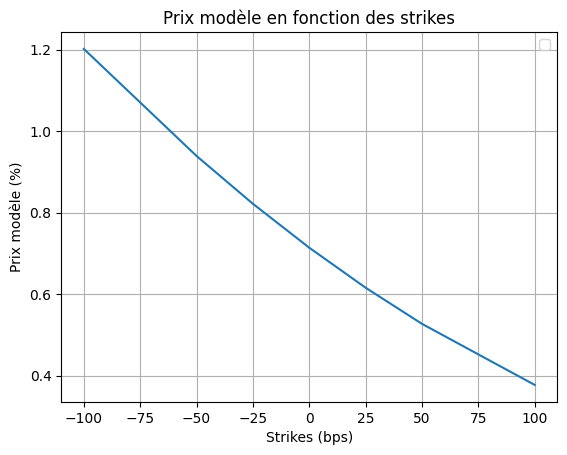

In [77]:
plt.plot(strikes*10_000, caplets*100)

plt.xlabel("Strikes (bps)")
plt.ylabel("Prix modèle (%)")
plt.title("Prix modèle en fonction des strikes")
plt.legend()
plt.grid()
plt.show()

---
2. Inversons ces prix modèle à l’aide de la fonction de Black pour calculer les volatilités implicites. 

Les volatilités implicites retrouvés pour ces prix modèles sont resumés dans le tableau ci après:

In [80]:
# Inversion des prix pour retrouver la vol implicite

L_i = (Z-1)/(T_i-T_i_1)
vols = np.array([dichot(t,L_i, strike + K, T_i_1, T_i, B, caplet) for strike,caplet in zip(strikes,caplets)])
#vols_inst = np.array([sigma(T_i_1, T_i, lambd, vol=vol) for vol in vols])



# Préparation des données pour le tableau
table_data = []
for i in range(len(caplets)):
    table_data.append([strikes[i]*10_000, np.round(vols[i]*100,2), np.round(caplets[i]*100,2)])

# Affichage des résultats dans un tableau
headers = ["Strike (bps)", "Vol implicite (%)", "Prix Modèle du Caplet (%)"]
print(tabulate(table_data, headers=headers, tablefmt="pretty", floatfmt=".4f"))

+--------------+-------------------+---------------------------+
| Strike (bps) | Vol implicite (%) | Prix Modèle du Caplet (%) |
+--------------+-------------------+---------------------------+
|    -100.0    |       28.87       |           [1.2]           |
|    -50.0     |       26.74       |          [0.94]           |
|    -25.0     |       25.83       |          [0.82]           |
|     0.0      |       25.0        |          [0.71]           |
|     25.0     |       24.24       |          [0.62]           |
|     50.0     |       23.55       |          [0.53]           |
|    100.0     |       22.3        |          [0.38]           |
+--------------+-------------------+---------------------------+


---

**Comparons le smile modèle avec le smile de marché**

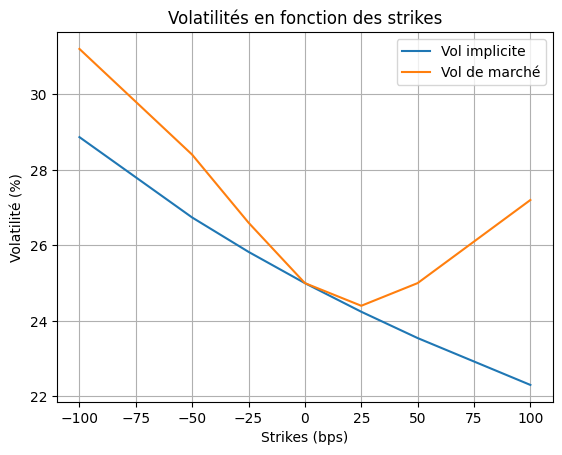

In [82]:
vol_mkt = np.array([31.2, 28.4, 26.6, 25.0, 24.4, 25.0, 27.2])

plt.plot(strikes*10_000, vols*100, label="Vol implicite")
plt.plot(strikes*10_000, vol_mkt, label="Vol de marché")

plt.xlabel("Strikes (bps)")
plt.ylabel("Volatilité (%)")
plt.title("Volatilités en fonction des strikes")
plt.legend()
plt.grid()
plt.show()

---

On observe pour ce modèle un **Skew-Smile**. Le modèle de Hull \& white n'arrive pas à reproduire le smile de marché. .

---
---

## Valorisation d’un produit structuré

Nous souhaitons valoriser un caplet 
- de strike K, 
- de dates de fixing $T_i$ et de paiement $T_{i+1},
-  avec une barrière désactivante $B$ telle que $B > K$.

1. Écrivons le payoff de l’option décrite et traçons la fonction de payoff en fonction de $L_i(T_i)$.
    Le  payoff l'option  s’écrit :

    $$
    \text{Payoff}_{T_{i+1}} = \delta_i \cdot (L_i(T_i) - K)^+ \cdot \mathbb{1}_{\{ L_i(T_i) < B \}}
    $$

    avec $\delta_i = T_{i+1}-T_i$.

    Il correspond à celui d’un caplet classique, mais est nul lorsque le taux Libor au fixing dépasse la barrière.

    Ainsi, fonction de payoff est donc nulle pour  $L_i(T_i) < K$ ou $L_i(T_i) \geq B$, et croît linéairement entre $K$ et $ B$.

    Une representation de la fonction de payoff est donnée la figure ci-dessous.

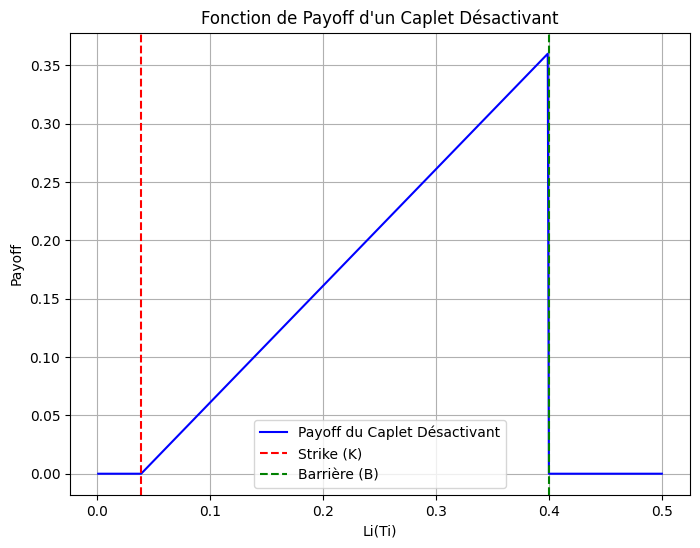

In [84]:
#3.7. 
#1. Payoff et courbe
# Définition des paramètres
delta = 1
Z_T = 1.05  # Exemple de valeur pour Z_T
B = 0.4  # Barrière (B)

# Définition des valeurs possibles pour Li(Ti)
Li_Ti = np.linspace(0.001, 0.5, 500)

# Calcul du payoff du caplet désactivant
payoff = np.maximum(0, Li_Ti - K) * (Li_Ti < B)

# Tracé de la fonction de payoff
plt.figure(figsize=(8, 6))
plt.plot(Li_Ti, payoff, label='Payoff du Caplet Désactivant', color='b')
plt.axvline(x=K, color='r', linestyle='--', label='Strike (K)')
plt.axvline(x=B, color='g', linestyle='--', label='Barrière (B)')
plt.title('Fonction de Payoff d\'un Caplet Désactivant')
plt.xlabel('Li(Ti)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

---


Cette option est moins chère qu’un caplet classique de strike  $K$  car elle comporte une barrière désactivante qui limite le risque pour le vendeur. En effet, dès que le taux dépasse  $B $, le caplet est désactivé, ce qui protège le vendeur contre les scénarios de forte hausse des taux.

Du point de vue de l’acheteur, cette protection a un coût : l’option devient moins attractive, car elle ne couvre plus les situations les plus défavorables. La probabilité de recevoir un payoff est donc réduite, ce qui justifie un prix plus bas par rapport à un caplet standard.


2. Le payoff de cet option est semblable à celui de:
   - l'achat d'un call de stkire K: $(L_i(T_i) - K)^+$ , 
   - de la vente d'un call de strike B: $-(L_i(T_i) - B)^+$,
   -  et d'un paiement fixe déclenché par le franchissement de la barrière: $-(B-K)\mathbb{1}_{\{ L_i(T_i) > B \}}$
  Le payoff peut alors se réécrire comme suit :

  $$
    \text{Payoff}_{T_{i+1}} = \delta_i \cdot( (L_i(T_i) - K)^+ -(L_i(T_i) - B)^+ -(B-K)\mathbb{1}_{\{ L_i(T_i) > B \}})
    $$


3. CLa méthode de Monte-Carlo repose sur des simulations aléatoires pour estimer la valeur attendue d’un payoff futur, actualisé à aujourd’hui. Cette méthode repose sur la loi des grands nombres : si l’on simule un grand nombre de scénarios possibles pour l’évolution du sous-jacent (les taux d’intérêt pour ce qui nous concerne), la moyenne des payoffs actualisés converge vers le prix théorique de l’instrument

4. On peut générer une variable gaussienne standard $Z \sim \mathcal{N}(0,1)$ à partir d'une variable uniforme $U \sim \mathcal{U}(0,1)$ en utilisant la réciproque de la fonction de répartition:

   $$
     Z = \Phi^{-1}(U)
   $$   
---

In [85]:
# Ceci est une version passant par la formule fermée. Pas fonctionnel
def X_t(t, T, sig, lambd, M=100):
    mu_t = 0.5*(sig**2 /lambd**2)*(np.exp(-lambd*T) + np.exp(-2*lambd*t) + np.exp(-lambd*(T+t)) - 1)    
    sig_t = np.sqrt((sig**2)*(1-np.exp(-2*lambd*t))/(2*lambd))
    return  np.random.normal(mu_t,sig_t, size=M )
    
    

def option_vanille(T, delta, K, sig, lambd, barrier, t=0):
    X = X_t(t, T, sig, lambd, M=10_000)
    L_i = np.array([((1/B(T,T+delta,x, lambd, sig)) - 1)/delta for x in X])
    L_i_B = np.array((L_i < barrier).astype(int))
    payoff = np.multiply(np.maximum(L_i - K,0), L_i_B)
    B_T_delta =  float(yield_zc[yield_zc.MAT == T+delta]["B(0,MAT)"].iloc[0])
    return B_T_delta*np.mean(payoff)

In [88]:
def B(t,T, x, lambd, sig):
    
    def beta(t,T):
        return (1- np.exp(-lambd*(T-t)))/lambd

    def phi(t):
        return (sig**2)*(1-np.exp(-2*lambd*t))/(2*lambd)
    
    B_t = float(yield_zc[yield_zc.MAT==t]["B(0,MAT)"].iloc[0])
    B_T =  float(yield_zc[yield_zc.MAT==T]["B(0,MAT)"].iloc[0])
    
    bet = beta(t,T)
    B_t_T = (B_T/B_t) * np.exp(-0.5*phi(t)*(bet**2)-bet*x)
    
    return B_t_T


def option_vanille(T, delta, K, sig, lambd, barrier, M=10_000):

    # Number of time steps (daily steps for T years)
    n = round(T * 252)
    Delta = T / n  # Time step size
    t_vec = np.arange(1, n + 1) * Delta  # Time steps

    # Simulate paths of X_t
    X = np.zeros((M, n))
    for t in range(n - 1):
        phi_t = (sig**2 / (2 * lambd)) * (1 - np.exp(-2 * lambd * t_vec[t]))
        gamma_t_T = (sig / lambd) * (np.exp(-lambd * (T - t_vec[t])) - 1)
        
        # Euler-Maruyama discretization
        X[:, t + 1] = X[:, t] + (phi_t + sig * gamma_t_T - lambd * X[:, t]) * Delta + sig * np.sqrt(Delta) * np.random.normal(0, 1, size=M)

    # Calculate Libor rates for each path
    L_i = np.array([((1 / B(T, T + delta, X[:, t], lambd, sig)) - 1) / delta for t in range(n)])

    # Barrier condition
    L_i_B = (L_i[-1,:] < barrier).astype(int)

    # Payoff calculation
    payoff = np.maximum(L_i[-1,:] - K, 0) * L_i_B

    # Discounting
    B_T_delta = float(yield_zc[yield_zc.MAT == T + delta]["B(0,MAT)"].iloc[0])
    option_price = B_T_delta * np.mean(payoff)
    #plt.plot(L_i[:,:1000])

    return option_price


5. On considère un caplet sur euribor12M à barrière désactivante 
   - de strike $ATM-100$  bps, 
   - de barrière $ATM+100$ 100 bps et 
   - de maturité 5Y.
    Alors, sa valeur calculée à l’aide de la méthode de Monte-Carlo est de \textbf{0.29\%}.

---

In [89]:
np.random.seed(90) # Pour la reproductibilité

barrier = L_0 + 100/ 10_000 
K = L_0 - 100/ 10_000

L = option_vanille(T = 5, delta = 1, K = K, sig = vol_inst, lambd = lambd, barrier = barrier, M=10_000)
print(L)

0.002952664054116537


 6. La dégénération du produit en faisant tendre la barrière vers 0 et $+\infty$ est donnée par la figure ci-dessous. 

    - On contate que le prix de l'option tend à s'annuler à mesure que la barrière tends vers 0 et il tend à être constant à mesure que la barrière tend vers $+\infty$. 
    - Ceci traduit le fait que l'option devient de moins en moins attractifs pour des barrières très basses et s'apprécie pour des barrières élevées (il devient moins probable de la franchir).

---

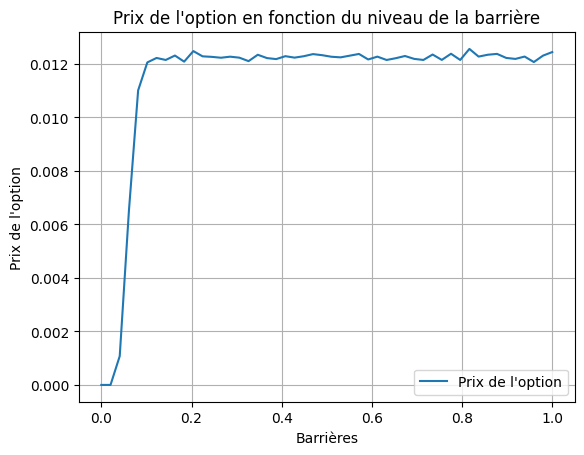

In [90]:
np.random.seed(90)

barriers = np.linspace(0,1, num=50) # Différentes barrières
K = L_0 - 100/ 10_000

caplets_barrier = np.array([option_vanille(T = 5, delta = 1, K = K, sig = vol_inst, lambd = lambd, barrier = barrier) for barrier in barriers])

plt.plot(barriers, caplets_barrier, label ="Prix de l'option")
plt.xlabel("Barrières")
plt.ylabel("Prix de l'option")
plt.legend()
plt.title("Prix de l'option en fonction du niveau de la barrière")
plt.grid(True)
plt.show()

In [ ]:
np.random.seed(90)

barrier = 10 # Barrière à 1000%
K = L_0 
L = option_vanille(T = 5, delta = 1, K = L_0, sig = vol_inst, lambd = lambd, barrier = barrier, M=10_000)
print(L)

0.007179683096335368


7. La barrière est rendue "bermudéenne" en étendant la condition de désactivation aux dates 1Y, 2Y, 3Y, 4Y et 5Y. 
   La nouvelle fonction de payoff s'écrit:
    
    \begin{align*}
        \text{Payoff}_{T_{i+1}} &= \begin{cases}
            \delta_i \cdot (L_i(T_i) - K)^+ \text{ si aucune la barrière n'est franchie en aucune date } T_j \\
            0 \text{ si la barrière est franchie au moins une fois}
        \end{cases} \\
        &=\delta_i \cdot (L_i(T_i) - K)^+ \cdot \mathbb{1}_{\{max_{1\leq j \leq 5} L_i(T_j) < B \}}\\  
    \end{align*}

In [92]:
# Pricer d'une option bermudéenne

def option_vanille_bermude(T, delta, K, sig, lambd, barrier, M=10_000):
    """
    Valorisation d'un caplet avec barrière bermudéenne via Monte Carlo.

    Paramètres :
    - T : Dates d'exercice bermudéennes (ex. [1, 2, 3, 4, 5] ans)
    - delta : Intervalle de temps entre la date de fixing et la date de paiement
    - K : Strike du caplet
    - sig : Volatilité du taux d'intérêt
    - lambd : Paramètre de régression vers la moyenne du taux court
    - barrier : Barrière désactivante
    - yield_zc : Courbe des taux zéro-coupon (DataFrame avec colonnes 'MAT' et 'B(0,MAT)')
    - M : Nombre de simulations Monte Carlo
    """

    # Discrétisation temporelle : pas de temps quotidien
    n = round(T[-1] * 252)  # Nombre total de pas de temps
    Delta = T[-1] / n  # Taille du pas de temps
    t_vec = np.arange(1, n + 1) * Delta  # Vecteur des dates simulées

    # Simulation des trajectoires du taux court via un processus de Vasicek/Hull-White
    X = np.zeros((M, n))
    for t in range(n - 1):
        phi_t = (sig**2 / (2 * lambd)) * (1 - np.exp(-2 * lambd * t_vec[t]))
        gamma_t_T = (sig / lambd) * (np.exp(-lambd * (T[-1] - t_vec[t])) - 1)
        
        # Euler
        X[:, t + 1] = X[:, t] + (phi_t + sig * gamma_t_T - lambd * X[:, t]) * Delta \
                       + sig * np.sqrt(Delta) * np.random.normal(0, 1, size=M)

    # Vérification de la désactivation bermudéenne aux dates spécifiques
    T_surveillance = np.array(T)  # Dates de surveillance de la barrière

    # Calcul des L_i aux dates de surveillance
    L_i_surveillance = np.zeros((M, len(T_surveillance)))
    for i, T_i in enumerate(T_surveillance):
        idx = round(T_i * 252) - 1  # Indice temporel à la date de surveillance
        L_i_surveillance[:, i] = ((1 / B(T_i, T_i + delta, X[:, idx], lambd, sig)) - 1) / delta  # Libor forward

    # Désactivation si la barrière est franchie à une date de surveillance
    barrier_crossed = np.any(L_i_surveillance >= barrier, axis=1)
    

    # Calcul des payoffs à la date de maturité
    idx = round(T[-1] * 252) - 1  # Indice temporel à la maturité
    L_i_maturity = ((1 / B(T[-1], T[-1] + delta, X[:, idx], lambd, sig)) - 1) / delta  # Libor forward

    # Payoff du caplet
    payoff = np.maximum(0, L_i_maturity - K)  # Payoff à la maturité
    payoff[barrier_crossed] = 0  # Désactivation complète

    # Actualisation et valorisation
    B_T_delta = float(yield_zc[yield_zc.MAT == T[-1] + delta]["B(0,MAT)"].iloc[0])
    option_price = B_T_delta * np.mean(payoff)

    return np.array([option_price, np.mean(barrier_crossed)]) # retourn le prix de l'option ainsi que 
                                                            # la proba de franchissement de la barrière

In [93]:
np.random.seed(90)

barrier = L_0 + 100/ 10_000
K = L_0 - 100/ 10_000

cap = option_vanille_bermude(T = np.array([1,2,3,4,5]), delta = 1, K = K, sig = vol_inst, lambd = lambd, barrier = barrier)

print("Prix de l'option bermudéenne: \t", round(cap[0]*100,2), "%")
print("Probabilité d'atteinte de la barrière: \t", round(cap[1]*100, 2), "%")

Prix de l'option bermudéenne: 	 0.22 %
Probabilité d'atteinte de la barrière: 	 40.78 %


Avec un strike $ATM-100$ et une barrière $ATM+100$, le prix de cette option est de $0.22\%$.

- On constate que cette option est moins chère que la précédente. 
- Ce résultat est conforme à nos attentes. En effet, avec plus de conditions de désactivation, l'option bermudéenne a une valeur intrinsèque plus faible, car elle est plus susceptible d'être désactivée avant la date de maturité.
-  Cela reflète le fait que le porteur de l'option est exposé à un risque plus élevé de perdre son payoff, tandis que le vendeur se protège contre des variations défavorables des taux à plusieurs dates. 

---

8. L'impact de la mean reversion sur la valorisation de l’option est illustré par la figure ci-après.

   *NB*:  Le modèle est recalibré sur le même caplet ATM pour chaque valeur de mean-reversion

C:\Users\DEBA\AppData\Local\Temp\ipykernel_24336\2495096927.py:4: RuntimeWarning: invalid value encountered in scalar divide
  beta = (1-np.exp(-lambd*(T_i - T_i_1)))/lambd
C:\Users\DEBA\AppData\Local\Temp\ipykernel_24336\2495096927.py:5: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt((2*lambd*T_i_1)/(1-np.exp(-2*lambd*T_i_1))) * vol / beta


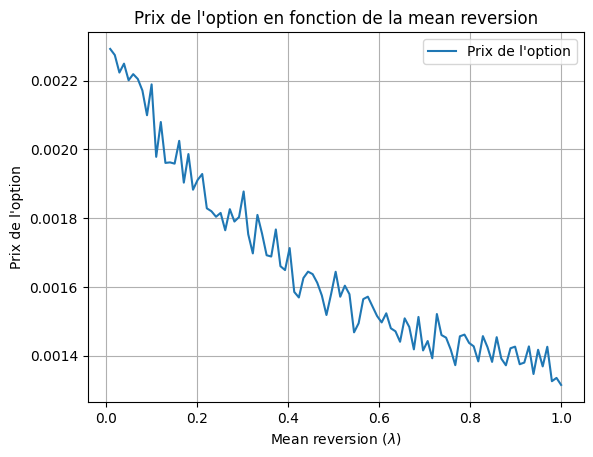

In [94]:
barrier = L_0 + 100/ 10_000
K = L_0 - 100/ 10_000

lambdas = np.linspace(0,1, num=100)
cap_mean_rev = np.array([option_vanille_bermude(T = np.array([1,2,3,4,5]), delta = 1, K = K,
                                                sig = sigma(5, 6, lambd, vol=vol_imp), # On recalibre la vol pour chaque lambda
                                                lambd = lambd,
                                                barrier = barrier) for lambd in lambdas] )

plt.plot(lambdas, cap_mean_rev[:,0], label ="Prix de l'option")
plt.xlabel("Mean reversion ($\lambda$)")
plt.ylabel("Prix de l'option")
plt.legend()
plt.title("Prix de l'option en fonction de la mean reversion")
plt.grid(True)
plt.show()


---

- On observe qu'une mean reversion faible augmente la valeur de l’option. En effet, le taux se stabilise autour de sa moyenne de long terme, réduisant la probabilité de franchissement de la barrière.   
- À l’inverse, une mean reversion forte  diminue la valeur de l’option, car elle rend le taux plus volatile et moins prévisible.

---

9. Probabilité d'atteinte de la barrière en fonction de la mean reversion

   - On peut déduire de ce qui précède que la probabilité de toucher la barrière croît lorsque la mean reversion décroît. 
   - Une estimation faite en valorisant l'option illutrer d'ailleurs cette analyse (voir figure i-dessous). Il apparaît clairement qu'il devient de plus en plus probable de franchir la barrière pour des mean reversion fortes.
  
**Il est à noter que ces observations faite pour la mean reversion et la probabilité d'atteinte de la barrière est inversée lorsque le modèle n'est pas recalibré pour chaque valeur de $\lambda$.**

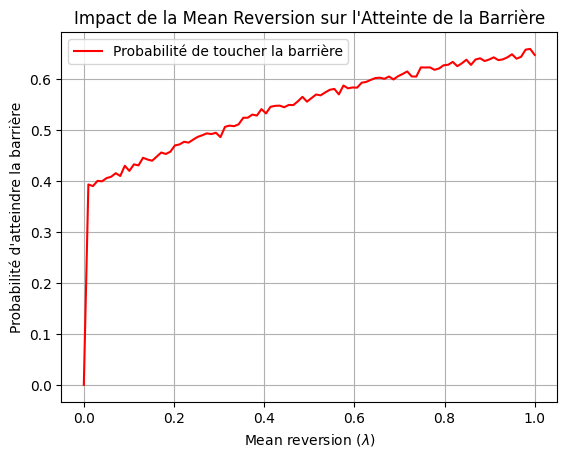

In [95]:

plt.plot(lambdas, cap_mean_rev[:,1],  linestyle='-', color='r', label="Probabilité de toucher la barrière")
plt.xlabel("Mean reversion ($\lambda$)")
plt.ylabel("Probabilité d'atteindre la barrière")
plt.title("Impact de la Mean Reversion sur l'Atteinte de la Barrière")
plt.grid(True)
plt.legend()
plt.show()
